In [ ]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
!head ./data/amazon90000.tsv

marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	12190288	R3FU16928EP5TC	B00AYB1482	668895143	Enlightened: Season 1	Digital_Video_Download	5	0	0	N	Y	I loved it and I wish there was a season 3	I loved it and I wish there was a season 3... I watched season 2 and loved that as well!	2015-08-31
US	30549954	R1IZHHS1MH3AQ4	B00KQD28OM	246219280	Vicious	Digital_Video_Download	5	0	0	N	Y	As always it seems that the best shows come from England	As always it seems that the best shows come from England. best of the best without words, i cant wait to watch season two.	2015-08-31
US	52895410	R52R85WC6TIAH	B01489L5LQ	534732318	After Words	Digital_Video_Download	4	17	18	N	Y	Charming movie	This movie isn't perfect, but it gets a lot of things right. Yes, the librarian character played by Marcia Gay Harden is stereotypical and played a bit heavy-handed. But the

In [3]:
df = pd.read_csv('./data/amazon90000.tsv', delimiter='\t')
df.shape

(88395, 15)

In [4]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Clean commas from raw text

In [5]:
df_scrubbed = df

df_scrubbed['marketplace'] = df_scrubbed['marketplace'].replace(',', ' ')
df_scrubbed['review_id'] = df_scrubbed['review_id'].replace(',', ' ')
df_scrubbed['product_id'] = df_scrubbed['product_id'].replace(',', ' ')
df_scrubbed['product_title'] = df_scrubbed['product_title'].replace(',', ' ')
df_scrubbed['product_category'] = df_scrubbed['product_category'].replace(',', ' ')
df_scrubbed['review_headline'] = df_scrubbed['review_headline'].replace(',', ' ')
df_scrubbed['review_body'] = df_scrubbed['review_body'].replace(',', ' ')
df_scrubbed['review_date'] = df_scrubbed['review_date'].replace(',', ' ')

df_scrubbed.shape

(88395, 15)

In [6]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop NaNs

In [7]:
df_scrubbed.isna().values.any()

True

In [8]:
df_scrubbed = df.dropna()
df_scrubbed = df_scrubbed.reset_index(drop=True)
df_scrubbed.shape

(88391, 15)

In [9]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


In [10]:
df_scrubbed['is_positive_sentiment'] = (df_scrubbed['star_rating'] >= 4).astype(int)
df_scrubbed.shape

(88391, 16)

In [11]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,is_positive_sentiment
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31,1
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31,1
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,1
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31,1
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31,1


# Write the data file locally

In [12]:
# $S3_BUCKET/feature-store/amazon-reviews/scrubbed-raw-with-header/data.csv

prefix = 'feature-store/amazon-reviews/scrubbed-raw-with-header'

scrubbed_raw_with_header_path = './{}/data.csv'.format(prefix)

import os
os.makedirs(prefix, exist_ok=True)

df_scrubbed.to_csv(scrubbed_raw_with_header_path, index=False, header=True)


# Upload to S3

In [13]:
df_scrubbed_raw_with_header_s3_uri = sess.upload_data(path=scrubbed_raw_with_header_path, key_prefix=prefix)

print(df_scrubbed_raw_with_header_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/scrubbed-raw-with-header/data.csv


In [14]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_scrubbed)


# Balance the Dataset between Classes

In [15]:
from sklearn.utils import resample

is_negative_sentiment_df = df_scrubbed.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_scrubbed.query('is_positive_sentiment == 1')

# TODO:  check which sentiment has the least number of samples

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False,
                                      n_samples = len(is_negative_sentiment_df),
                                      random_state = 27)

df_balanced_raw = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])
df_balanced_raw = df_balanced_raw.reset_index(drop=True)

In [16]:
df_balanced_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,is_positive_sentiment
0,US,38805573,RH4SXPL4L9QU,B00XWV4QXG,633842417,Entourage: Season 7,Digital_Video_Download,3,0,0,N,Y,it was not as good as the series,"Strange as it is, it was not as good as the se...",2015-08-31,0
1,US,37100714,R37INWIQA5YW8N,B00X8UKOUK,666093513,Catastrophe - Season 1,Digital_Video_Download,2,0,0,N,Y,Two Stars,"Funny shows! We laughed out loud, alot!",2015-08-31,0
2,US,41234409,R18GSVAAS3N8GX,B00OOKXTFU,801680808,The Worricker Trilogy Season 1,Digital_Video_Download,3,0,0,N,Y,A tad Stuffy,Well made. Great actors! Christopher Walken ma...,2015-08-31,0
3,US,12411752,R2SWNCCEH2HPM5,B01347T9O8,331499516,Casanova,Digital_Video_Download,1,0,0,N,Y,One Star,"Not my kind of movie, one star was too much",2015-08-31,0
4,US,14717869,R127KV8E8ZC5L4,B00EC7VQX2,627579257,Boardwalk Empire Season 3,Digital_Video_Download,1,0,1,N,Y,I would have given it a 4 but since I ...,I would have given it a 4 but since I can't ge...,2015-08-31,0


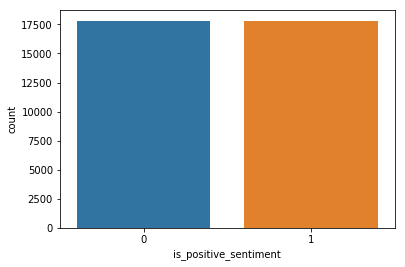

In [17]:
sns.countplot(x='is_positive_sentiment', data=df_balanced_raw)


In [18]:
df_balanced_raw_only_2_columns = df_balanced_raw[['is_positive_sentiment', 'review_body']]
#df_y_balanced_raw = df_balanced_raw['is_positive_sentiment']

df_balanced_raw_only_2_columns.shape

(35616, 2)

# Write the data file locally

In [19]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-raw-with-header/data.csv

prefix = 'feature-store/amazon-reviews/balanced-raw-with-header'

balanced_raw_with_header_path = './{}/data.csv'.format(prefix)

import os
os.makedirs(prefix, exist_ok=True)

df_balanced_raw_only_2_columns.to_csv(balanced_raw_with_header_path, index=False, header=True)


# Upload to S3

In [20]:
df_balanced_raw_with_header_s3_uri = sess.upload_data(path=balanced_raw_with_header_path, key_prefix=prefix)

print(df_balanced_raw_with_header_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-raw-with-header/data.csv


# TF/IDF Feature Engineering

# Transform the raw text into TF/IDF features

In [21]:
# Features (X)
df_X_balanced_raw = df_balanced_raw[['review_body']]
# Labels (y)
df_y_balanced_raw = df_balanced_raw['is_positive_sentiment']

print('X.shape:  {}'.format(df_X_balanced_raw.shape))
print('y.shape:  {}'.format(df_y_balanced_raw.shape))

X.shape:  (35616, 1)
y.shape:  (35616,)


In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc('review_body'))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer',
             column_transformer), ('svd', TruncatedSVD(n_components=300)),
            ('standardscaler', StandardScaler())
        ]
    )

    return pipeline

In [ ]:
np_tfidf = feature_transform_fn(df_X_balanced_raw).fit_transform(df_X_balanced_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

In [ ]:
df_tfidf.head(5)

### Based on the following:  https://aws.amazon.com/blogs/machine-learning/flagging-suspicious-healthcare-claims-with-amazon-sagemaker/

_Note:  This takes a while.  Please be patient._

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=250, random_state=10)
new_values = tsne_model.fit_transform(new_df_tfidf)


In [ ]:
import matplotlib.pyplot as plt

# column 0-299
labels = df_tfidf.columns.values
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [ ]:
#vectorizer = TfidfVectorizer(stop_words='english')
#df_tfidf = vectorizer.fit_transform(text)

#feature_names = vectorizer.get_feature_names()
#print(feature_names)

#df_tfidf = pd.DataFrame(vectorizer.idf_, 
#                        index=vectorizer.get_feature_names(),
#                        columns=['idf'])

#df_tfidf = pd.DataFrame(X.todense(),columns=vectorizer.get_feature_names())
#df_tfidf.head(5)

# Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [ ]:
np_tfidf = transformer.fit_transform(df_X_balanced_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

In [ ]:
df_tfidf.head(5)

# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [ ]:
df_tfidf.insert(0, 'is_positive_sentiment', df_y_balanced_raw)
df_tfidf.shape

In [ ]:
df_tfidf.head(10)

# Randomly split the data into `train`, `validation`, and `test` datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_tfidf_train, df_tfidf_holdout = train_test_split(df_tfidf, test_size=0.1, random_state=0)

# Split the holdout into 50% validation and 50% test
df_tfidf_validation, df_tfidf_test = train_test_split(df_tfidf_holdout, test_size=0.5, random_state=0)

print('df_tfidf.shape={}'.format(df_tfidf.shape))
print('df_tfidf_train.shape={}'.format(df_tfidf_train.shape))
print('df_tfidf_validation.shape={}'.format(df_tfidf_validation.shape))
print('df_tfidf_test.shape={}'.format(df_tfidf_test.shape))

In [ ]:
df_tfidf_train.head(5)

# Write the datasets locally
_Note: `header=False`_

In [ ]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_train = 'feature-store/amazon-reviews/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}/data.csv'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

df_tfidf_train.to_csv(balanced_tfidf_without_header_train_path, index=False, header=False)
df_tfidf_validation.to_csv(balanced_tfidf_without_header_validation_path, index=False, header=False)
df_tfidf_test.to_csv(balanced_tfidf_without_header_test_path, index=False, header=False)


# Upload to S3

In [ ]:
df_balanced_tfidf_without_header_train_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_train_path, key_prefix=prefix_train)
df_balanced_tfidf_without_header_validation_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_train_path, key_prefix=prefix_validation)
df_balanced_tfidf_without_header_test_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_train_path, key_prefix=prefix_test)

print(df_balanced_tfidf_without_header_train_s3_uri)
print(df_balanced_tfidf_without_header_validation_s3_uri)
print(df_balanced_tfidf_without_header_test_s3_uri)


In [ ]:
!aws s3 ls $df_balanced_tfidf_without_header_train_s3_uri